#Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

#Cargar la información

In [3]:
df = pd.read_csv('Habitat-E.csv', index_col = 'Date', parse_dates = True)
df = df.asfreq('d') #Establece la frecuencia de la serie en diaria


In [4]:
df.isnull().sum()     #Verifica si existen valores nulos

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
del df['Open']
del df['High']
del df['Low']
del df['Volume']

#Separar los datos en un conjunto de entrenamiento y prueba

In [6]:
size = int(len(df)*0.8)
df_train, df_test = df[:size], df[size:]

## Se debe corroborar que no se repita la fecha entre el conjunto de entrenamiento y prueba

In [7]:
df_train.tail()

,Close
Date,
2019-11-21,41585
2019-11-22,41629
2019-11-23,41629
2019-11-24,41629
2019-11-25,41718


In [8]:
df_test.head()

,Close
Date,
2019-11-26,41863
2019-11-27,41976
2019-11-28,41985
2019-11-29,41915
2019-11-30,41915


#Analizar tendencia, estacionalidad y residuos de la serie

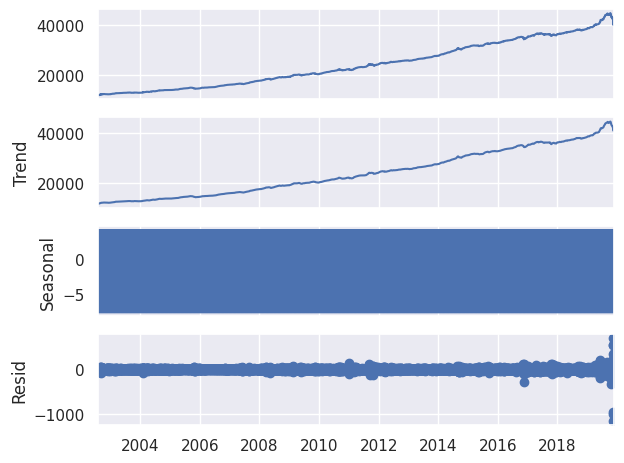

In [9]:
s_dec_additive = seasonal_decompose(df_train, model = 'additive')
s_dec_additive.plot()
plt.show()

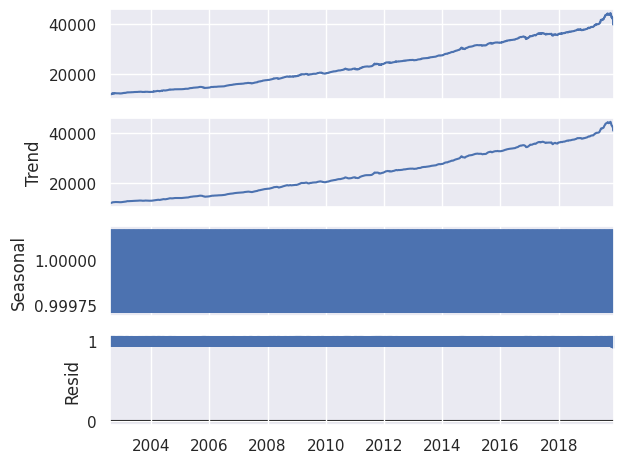

In [10]:
s_dec_multiplicative = seasonal_decompose(df_train, model = 'multiplicative')    #En ambos casos no se evidencia una estacionalidad, pero si una tendencia positiva
s_dec_multiplicative.plot()
plt.show()

#Análisis de estacionaridad

In [11]:
sts.adfuller(df_train.Close)     #Se obtuvo un valor P de 99% por lo que con una significancia de 5% existe evidencia de que no es una serie estacionaria

(1.4608997808718673,
 0.9973739770800493,
 32,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 63407.25471217314)

#Probar modelos que realicen la mejor predicción de la serie

##Se define una función de log verosimilitud que pueda comparar qué modelo es mejor

In [12]:
def LLR_test(mod_1, mod_2, DF = 1):             #DF son los grados de libertad y se calculan con la diferencia en la cantidad de parametros que se necesita entre ambas predicciones
  L1 = mod_1.llf                                #llf es para calcular log verosimilitud de cada predicción
  L2 = mod_2.llf
  LR = (2*(L2 - L1))
  p = chi2.sf(LR,DF).round(3)
  return p

##Modelos autoregresivos

###Crear los retornos

In [13]:
df_train['returns'] = df_train.Close.pct_change(1).mul(100)

<ipython-input-13-70c3f036e9fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['returns'] = df_train.Close.pct_change(1).mul(100)


In [14]:
df_train.head()

,Close,returns
Date,,
2002-08-01,11778,NaN
2002-08-02,11775,-0.025471
2002-08-03,11775,0.000000
2002-08-04,11775,0.000000
2002-08-05,11796,0.178344


In [15]:
sts.adfuller(df_train.returns[1:]) #Ahora si los retornos cumplen con la condición de ser estacionarios

(-11.891480431149372,
 5.854625974100925e-22,
 31,
 6293,
 {'1%': -3.4313895629133992,
  '5%': -2.8619993951727514,
  '10%': -2.567014533031778},
 -8415.189907521572)

###Módelo autoregresivo de orden 1

In [16]:
model_ar_1 = ARIMA(df_train.returns[1:], order = (1,0,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4000.832
Date:                Fri, 26 Apr 2024   AIC                          -7995.664
Time:                        23:53:07   BIC                          -7975.407
Sample:                    08-02-2002   HQIC                         -7988.648
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.009      0.000       0.016       0.024
ar.L1          0.1726      0.003     50.292      0.000       0.166       0.179
sigma2         0.0165   3.55e-05    465.027      0.000       0.016       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):          12876049.69
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       224.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###Modelo autoregresivo de orden 2

In [17]:
model_ar_2 = ARIMA(df_train.returns[1:], order = (2,0,0))
results_ar_2 = model_ar_2.fit()
print(results_ar_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_1,results_ar_2))) #Compara el modelo Autoregresivo de orden 1 con el de orden 2

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(2, 0, 0)   Log Likelihood                4004.473
Date:                Fri, 26 Apr 2024   AIC                          -8000.947
Time:                        23:53:14   BIC                          -7973.938
Sample:                    08-02-2002   HQIC                         -7991.592
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.655      0.000       0.016       0.025
ar.L1          0.1667      0.005     30.358      0.000       0.156       0.177
ar.L2          0.0339      0.008      4.400      0.0

###Modelo autoregresivo de orden 3

In [18]:
model_ar_3 = ARIMA(df_train.returns[1:], order = (3,0,0))
results_ar_3 = model_ar_3.fit()
print(results_ar_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_2,results_ar_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(3, 0, 0)   Log Likelihood                4057.316
Date:                Fri, 26 Apr 2024   AIC                          -8104.633
Time:                        23:53:24   BIC                          -8070.871
Sample:                    08-02-2002   HQIC                         -8092.940
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.802      0.000       0.016       0.024
ar.L1          0.1711      0.006     28.500      0.000       0.159       0.183
ar.L2          0.0554      0.008      6.974      0.0

###Modelo autoregresivo de orden 4

In [19]:
model_ar_4 = ARIMA(df_train.returns[1:], order = (4,0,0))
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_3,results_ar_4)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(4, 0, 0)   Log Likelihood                4060.680
Date:                Fri, 26 Apr 2024   AIC                          -8109.360
Time:                        23:53:35   BIC                          -8068.846
Sample:                    08-02-2002   HQIC                         -8095.328
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002     10.122      0.000       0.016       0.024
ar.L1          0.1669      0.006     28.472      0.000       0.155       0.178
ar.L2          0.0572      0.008      7.107      0.0

###Modelo autoregresivo de orden 5

In [20]:
model_ar_5 = ARIMA(df_train.returns[1:], order = (5,0,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_4,results_ar_5)))      #Para la quinta variable L5 se obtuvo un valor P mayor a 10% por lo que no significativamente distinta de 0
                                                                              # Además, de acuerdo a la prueba de hipótesis entre el modelo de orden 4 y 5, se obtuvo que no son significativamente diferentes

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(5, 0, 0)   Log Likelihood                4061.294
Date:                Fri, 26 Apr 2024   AIC                          -8108.589
Time:                        23:53:44   BIC                          -8061.323
Sample:                    08-02-2002   HQIC                         -8092.218
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002     10.243      0.000       0.016       0.024
ar.L1          0.1664      0.006     28.626      0.000       0.155       0.178
ar.L2          0.0555      0.008      7.083      0.0

In [21]:
model_ar_6 = ARIMA(df_train.returns[1:], order = (6,0,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_5,results_ar_6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(6, 0, 0)   Log Likelihood                4068.872
Date:                Fri, 26 Apr 2024   AIC                          -8121.744
Time:                        23:53:51   BIC                          -8067.725
Sample:                    08-02-2002   HQIC                         -8103.035
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.745      0.000       0.016       0.024
ar.L1          0.1671      0.006     28.735      0.000       0.156       0.178
ar.L2          0.0566      0.008      6.992      0.0

#Gráfico de autocorrelación parcial

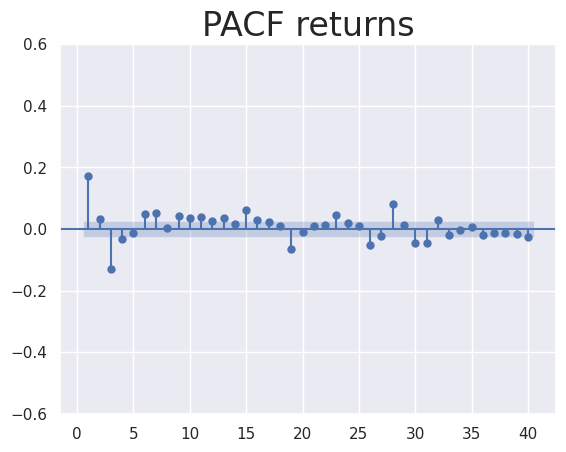

In [22]:
sgt.plot_pacf(df_train.returns[1:], lags = 40, zero = False, method = ('ols'))   #De acuerdo al gráfico y los valores obtenidos se explica que el quinto retraso no es
plt.title('PACF returns', size = 24)                                             #Significativamente distinto de 0, además basandose en el gráfico se probará en el valor 16 de retrasos
plt.ylim(-0.6, 0.6)
plt.show()

In [23]:
model_ar_16 = ARIMA(df_train.returns[1:], order = (16,0,0))
results_ar_16 = model_ar_16.fit()
print(results_ar_16.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_6,results_ar_16, DF = 10))) #Si bien, de acuerdo a la prueba de hipótesis se obtiene que L16 es un mejor modelo que L6, se obtuvieron
                                                                                    #que L8, L10, L12 y L14 tienen valores signifitivamente iguales a 0, por lo que se optará por probar con L7 y L8

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(16, 0, 0)   Log Likelihood                4104.796
Date:                Fri, 26 Apr 2024   AIC                          -8173.592
Time:                        23:54:19   BIC                          -8052.051
Sample:                    08-02-2002   HQIC                         -8131.497
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.003      7.056      0.000       0.015       0.026
ar.L1          0.1582      0.007     23.775      0.000       0.145       0.171
ar.L2          0.0517      0.010      5.361      0.0

In [24]:
model_ar_7 = ARIMA(df_train.returns[1:], order = (7,0,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_6,results_ar_7)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(7, 0, 0)   Log Likelihood                4077.269
Date:                Fri, 26 Apr 2024   AIC                          -8136.538
Time:                        23:54:46   BIC                          -8075.768
Sample:                    08-02-2002   HQIC                         -8115.491
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.231      0.000       0.016       0.024
ar.L1          0.1646      0.006     27.909      0.000       0.153       0.176
ar.L2          0.0578      0.009      6.547      0.0

In [25]:
model_ar_8 = ARIMA(df_train.returns[1:], order = (8,0,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ar_7,results_ar_8)))   #Se obtuvo que el mejor modelo es el de AR de orden 7

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(8, 0, 0)   Log Likelihood                4077.300
Date:                Fri, 26 Apr 2024   AIC                          -8134.600
Time:                        23:54:55   BIC                          -8067.077
Sample:                    08-02-2002   HQIC                         -8111.214
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.166      0.000       0.016       0.024
ar.L1          0.1646      0.006     27.509      0.000       0.153       0.176
ar.L2          0.0579      0.009      6.493      0.0

#Análisis de residuos

In [ ]:
df_train['residuos_ar7'] = results_ar_7.resid

#Modelos de medias móviles

##Modelo medias moviles de orden 1

In [27]:
model_ma_1 = ARIMA(df_train.returns[1:], order = (0,0,1))
results_ma_1 = model_ma_1.fit()
print(results_ma_1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 1)   Log Likelihood                3989.755
Date:                Sat, 27 Apr 2024   AIC                          -7973.509
Time:                        00:02:03   BIC                          -7953.252
Sample:                    08-02-2002   HQIC                         -7966.493
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.360      0.000       0.016       0.024
ma.L1          0.1510      0.004     38.805      0.000       0.143       0.159
sigma2         0.0166   3.19e-05    519.138      0.0

##Modelo medias móviles de orden 2

In [33]:
model_ma_2 = ARIMA(df_train.returns[1:], order = (0,0,2))
results_ma_2 = model_ma_2.fit()
print(results_ma_2.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_1,results_ma_2)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 2)   Log Likelihood                4022.527
Date:                Sat, 27 Apr 2024   AIC                          -8037.053
Time:                        00:10:02   BIC                          -8010.044
Sample:                    08-02-2002   HQIC                         -8027.699
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.914      0.000       0.016       0.024
ma.L1          0.1824      0.005     40.442      0.000       0.174       0.191
ma.L2          0.1092      0.005     20.153      0.0

#Modelo medias móviles de orden 3

In [34]:
model_ma_3 = ARIMA(df_train.returns[1:], order = (0,0,3))
results_ma_3 = model_ma_3.fit()
print(results_ma_3.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_2,results_ma_3)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 3)   Log Likelihood                4042.623
Date:                Sat, 27 Apr 2024   AIC                          -8075.247
Time:                        00:10:18   BIC                          -8041.486
Sample:                    08-02-2002   HQIC                         -8063.554
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.266      0.000       0.016       0.024
ma.L1          0.1655      0.006     28.694      0.000       0.154       0.177
ma.L2          0.0806      0.006     12.620      0.0

#Gráfico de autocorrelación

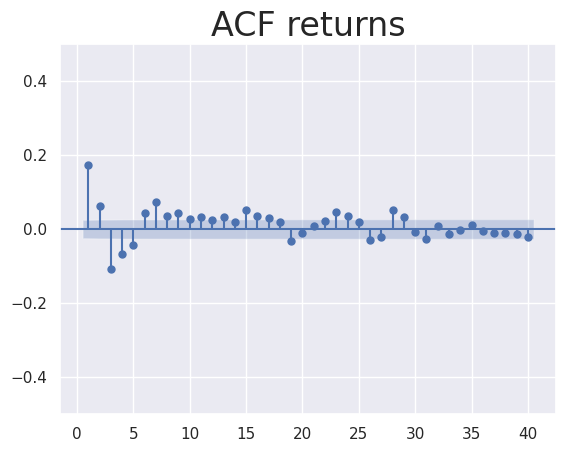

In [32]:
#Cuando se utilizan modelos de medias móviles se puede utilizar un gráfico de autocorrelación para saber datos sobre que retrocesos son significativos
sgt.plot_acf(df_train.returns[1:], lags = 40, zero = False)
plt.title('ACF returns', size = 24)                               #De acuerdo al gráfico hasta el retroceso 18 las constantes son significativas, pero no se pueden
plt.ylim(-0.5, 0.5)                                               #Incluir tantas porque se puede caer en el riesgo de overfiting
plt.show()

##Modelo de medias móviles con 15 retrasos

In [40]:
model_ma_15 = ARIMA(df_train.returns[1:], order = (0,0,15))  #Se obtuvieron dos coeficientes que no son significativos (L10 y L14)
results_ma_15 = model_ma_15.fit()
print(results_ma_15.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 15)   Log Likelihood                4099.935
Date:                Sat, 27 Apr 2024   AIC                          -8165.871
Time:                        00:19:49   BIC                          -8051.082
Sample:                    08-02-2002   HQIC                         -8126.114
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.003      7.969      0.000       0.015       0.025
ma.L1          0.1595      0.006     25.754      0.000       0.147       0.172
ma.L2          0.0762      0.008      9.103      0.0

#Modelo de medias móviles con 9 retrasos

In [39]:
model_ma_9 = ARIMA(df_train.returns[1:], order = (0,0,9))
results_ma_9 = model_ma_9.fit()
print(results_ma_9.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_3,results_ma_9, DF = 6)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                 ARIMA(0, 0, 9)   Log Likelihood                4083.259
Date:                Sat, 27 Apr 2024   AIC                          -8144.518
Time:                        00:18:46   BIC                          -8070.243
Sample:                    08-02-2002   HQIC                         -8118.793
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      9.076      0.000       0.016       0.024
ma.L1          0.1618      0.006     27.135      0.000       0.150       0.174
ma.L2          0.0800      0.008     10.027      0.0

In [41]:
model_ma_10 = ARIMA(df_train.returns[1:], order = (0,0,10))
results_ma_10 = model_ma_10.fit()
print(results_ma_10.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_9,results_ma_10, DF = 1)))  #Se obtiene que el modelo con 10 retrasos es mejor que el modelo con 9 retrasos

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 10)   Log Likelihood                4085.538
Date:                Sat, 27 Apr 2024   AIC                          -8147.076
Time:                        00:20:25   BIC                          -8066.049
Sample:                    08-02-2002   HQIC                         -8119.013
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.879      0.000       0.016       0.025
ma.L1          0.1616      0.006     26.419      0.000       0.150       0.174
ma.L2          0.0792      0.008     10.029      0.0

In [42]:
model_ma_11 = ARIMA(df_train.returns[1:], order = (0,0,11))
results_ma_11 = model_ma_11.fit()
print(results_ma_11.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_10,results_ma_11)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 11)   Log Likelihood                4087.861
Date:                Sat, 27 Apr 2024   AIC                          -8149.722
Time:                        00:22:16   BIC                          -8061.943
Sample:                    08-02-2002   HQIC                         -8119.320
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.002      8.696      0.000       0.016       0.025
ma.L1          0.1606      0.006     25.910      0.000       0.148       0.173
ma.L2          0.0782      0.008      9.757      0.0

In [43]:
model_ma_12 = ARIMA(df_train.returns[1:], order = (0,0,12))
results_ma_12 = model_ma_12.fit()
print(results_ma_12.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_11,results_ma_12)))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 12)   Log Likelihood                4090.332
Date:                Sat, 27 Apr 2024   AIC                          -8152.663
Time:                        00:23:27   BIC                          -8058.132
Sample:                    08-02-2002   HQIC                         -8119.923
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.002      8.509      0.000       0.016       0.025
ma.L1          0.1595      0.006     25.773      0.000       0.147       0.172
ma.L2          0.0787      0.008      9.869      0.0

In [44]:
model_ma_13 = ARIMA(df_train.returns[1:], order = (0,0,13))
results_ma_13 = model_ma_13.fit()
print(results_ma_13.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_12,results_ma_13)))  #Es un mejor modelo, pero se evidencia que L10 no es significativamente distinto de 0 para este modelo

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 13)   Log Likelihood                4094.181
Date:                Sat, 27 Apr 2024   AIC                          -8158.362
Time:                        00:24:54   BIC                          -8057.078
Sample:                    08-02-2002   HQIC                         -8123.282
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.295      0.000       0.015       0.025
ma.L1          0.1600      0.006     25.877      0.000       0.148       0.172
ma.L2          0.0764      0.008      9.554      0.0

In [45]:
model_ma_14 = ARIMA(df_train.returns[1:], order = (0,0,14))
results_ma_14 = model_ma_14.fit()
print(results_ma_14.summary())
print("\nLLR test p-value = " + str(LLR_test(results_ma_13,results_ma_14)))    #De acuerdo a la prueba de hipótesis este modelo no es mejor que el anterior, así que se queda el modelo 13

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 6325
Model:                ARIMA(0, 0, 14)   Log Likelihood                4094.256
Date:                Sat, 27 Apr 2024   AIC                          -8156.512
Time:                        00:26:16   BIC                          -8048.476
Sample:                    08-02-2002   HQIC                         -8119.094
                         - 11-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.002      8.231      0.000       0.015       0.025
ma.L1          0.1598      0.006     25.827      0.000       0.148       0.172
ma.L2          0.0763      0.008      9.487      0.0

#Análisis de residuos

,Close,returns,res_ret_ma_13
Date,,,
2002-08-01,11778,NaN,NaN
2002-08-02,11775,-0.025471,NaN
2002-08-03,11775,0.000000,-0.012302
2002-08-04,11775,0.000000,-0.015397
2002-08-05,11796,0.178344,0.156691


In [46]:
df_train['res_ret_ma_13'] = results_ma_13.resid[1:]

<ipython-input-46-8fcfc00f11ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['res_ret_ma_13'] = results_ma_13.resid[1:]


In [47]:
print("El promedio de los residuos es " + str(round(df_train.res_ret_ma_13.mean(),3)) + "\nLa varianza de los residuos es " + str(round(df_train.res_ret_ma_13.var(),3)) )

El promedio de los residuos es 0.0
La varianza de los residuos es 0.016


In [49]:
from math import sqrt
round(sqrt(df_train.res_ret_ma_13.var()),3)     #Se necesita que los residuos se comporten como ruido blanco gausiano

0.127

#GRáfico de los residuos

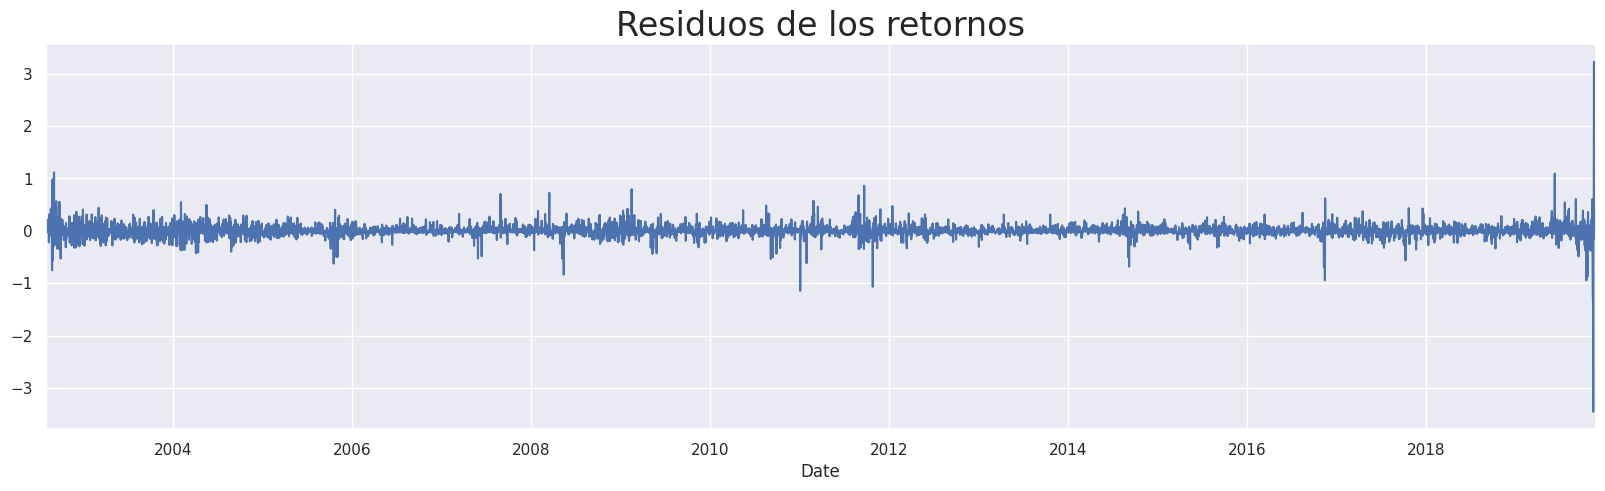

In [50]:
df_train.res_ret_ma_13.plot(figsize = (20,5))
plt.title("Residuos de los retornos", size = 24)
plt.show()

#Comprobación de estacionaridad de los residuos

In [51]:
sts.adfuller(df_train.res_ret_ma_13)

MissingDataError: exog contains inf or nans